In [ ]:
!pip install chainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=971824 sha256=bae655f34d0e260b7f4f620cd97cc2a6e5d22f72fb6d0829158bf9e57ee0c35a
  Stored in directory: /root/.cache/pip/wheels/c4/95/6a/16014db6f761c4e742755b64aac60dbe142da1df6c5919f790
Successfully built chainer


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.models import Sequential
from keras.optimizers import Adam
from keras import callbacks
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
veri = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", delimiter=',', skiprows=0, low_memory=False)
veri[' Label'].replace(['BENIGN', 'DDoS'], [0, 1], inplace=True)
moddf = veri.dropna()
if ' Flow Packets/s' in moddf.columns:
    del moddf[' Flow Packets/s']

In [ ]:
features = [col for col in moddf.columns if col != ' Label']
target = ' Label'

In [ ]:
X = moddf[features].copy()
y = moddf[target]

In [ ]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [ ]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1

print(f"Number of components to retain 95% of variance: {n_components}")

Number of components to retain 95% of variance: 21


In [ ]:
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X_scaled)

In [ ]:
selected_features = [features[i] for i in np.argsort(-pca.components_, axis=1)[:, 0]]
print(f"Columns selected after applying PCA: {selected_features}")

Columns selected after applying PCA: [' Fwd IAT Max', ' Avg Bwd Segment Size', 'Subflow Fwd Packets', ' Avg Fwd Segment Size', 'Active Mean', ' Fwd Packet Length Std', ' Active Max', ' RST Flag Count', ' Bwd Packet Length Min', 'Fwd Packets/s', 'Init_Win_bytes_forward', 'Fwd Packets/s', ' Active Std', ' Flow IAT Min', ' Bwd Packets/s', ' Active Std', ' Bwd Packets/s', ' min_seg_size_forward', 'Flow Bytes/s', ' min_seg_size_forward', ' Idle Std']


In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [ ]:
x_train = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))
x_test = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))

In [ ]:
print(f"NaN values in training data: {np.isnan(xtrain).sum()}")
print(f"NaN values in testing data: {np.isnan(xtest).sum()}")
print(f"NaN values in training labels: {np.isnan(ytrain).sum()}")
print(f"NaN values in testing labels: {np.isnan(ytest).sum()}")

NaN values in training data: 0
NaN values in testing data: 0
NaN values in training labels: 0
NaN values in testing labels: 0


In [ ]:
print(np.array(ytest))

[0 0 1 ... 0 1 0]


In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

In [ ]:
regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=10, return_sequences=True, input_shape=(x_train.shape[1], 1))))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=10))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='sigmoid'))

In [ ]:
regressor.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history = regressor.fit(x_train, ytrain, epochs=10, batch_size=128)

Epoch 1/10
1411/1411 [==============================] - 75s 44ms/step - loss: 0.1190 - acc: 0.9578
Epoch 2/10
1411/1411 [==============================] - 65s 46ms/step - loss: 0.0201 - acc: 0.9956
Epoch 3/10
1411/1411 [==============================] - 65s 46ms/step - loss: 0.0146 - acc: 0.9970
Epoch 4/10
1411/1411 [==============================] - 64s 45ms/step - loss: 0.0132 - acc: 0.9974
Epoch 5/10
1411/1411 [==============================] - 63s 44ms/step - loss: 0.0109 - acc: 0.9979
Epoch 6/10
1411/1411 [==============================] - 65s 46ms/step - loss: 0.0103 - acc: 0.9979
Epoch 7/10
1411/1411 [==============================] - 64s 46ms/step - loss: 0.0092 - acc: 0.9981
Epoch 8/10
1411/1411 [==============================] - 65s 46ms/step - loss: 0.0087 - acc: 0.9982
Epoch 9/10
1411/1411 [==============================] - 65s 46ms/step - loss: 0.0080 - acc: 0.9983
Epoch 10/10
1411/1411 [==============================] - 65s 46ms/step - loss: 0.0065 - acc: 0.9983


In [ ]:
trainloss = regressor.evaluate(x_train, ytrain, verbose=0)
testloss = regressor.evaluate(x_test, ytest, verbose=0)

In [ ]:
predict = regressor.predict(x_test)

1411/1411 [==============================] - 16s 10ms/step


In [ ]:
predict_binary = (predict > 0.5).astype(int)

In [ ]:
predDf = pd.DataFrame(np.array(ytest), columns=["Real_Values"])
predDf2 = pd.Series(predict.reshape(-1,), name='Predicted_Values')

In [ ]:
pred_results = pd.concat([predDf, predDf2], axis=1)

In [ ]:
predDf

,Real_Values
0,0
1,0
2,1
3,1
4,0
...,...
45144,0
45145,0
45146,0
45147,1


In [ ]:
print(pred_results.head())

   Real_Values  Predicted_Values
0            0          0.000070
1            0          0.000073
2            1          0.999977
3            1          0.999974
4            0          0.000080


In [ ]:
print("Accuracy: ", accuracy_score(ytest, predict_binary))
print("Precision: ", precision_score(ytest, predict_binary))
print("Recall: ", recall_score(ytest, predict_binary))
print("F1 Score: ", f1_score(ytest, predict_binary))

Accuracy:  0.9985824713725664
Precision:  0.9994162969880924
Recall:  0.9980957562568009
F1 Score:  0.9987555901224966


In [ ]:
regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=10, return_sequences=True, input_shape = (x_train.shape[1],1) ) )) #çıktı uzayının boyutu
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 10 , return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 10 , return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 10))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1,activation='sigmoid'))
regressor.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])

In [ ]:
history=regressor.fit(x_train, ytrain, epochs=3,batch_size=64 )

Epoch 1/3
2822/2822 [==============================] - 133s 42ms/step - loss: 0.0720 - acc: 0.9740
Epoch 2/3
2822/2822 [==============================] - 113s 40ms/step - loss: 0.0132 - acc: 0.9976
Epoch 3/3
2822/2822 [==============================] - 117s 41ms/step - loss: 0.0120 - acc: 0.9978


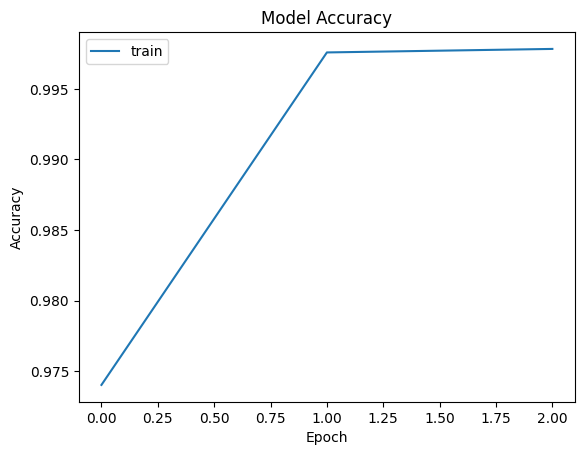

In [ ]:
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

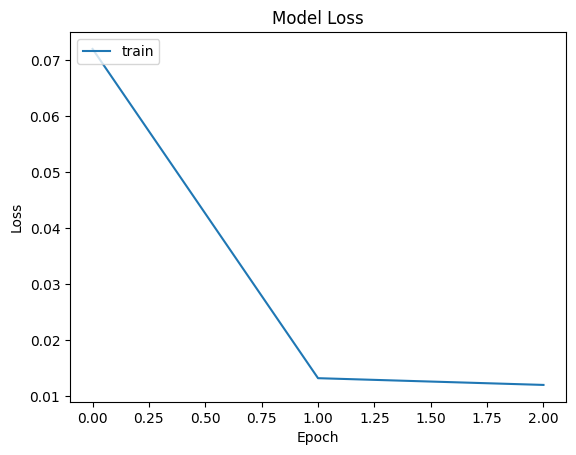

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()